# Character Classification
This notebook contains all steps of OCR

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# Import Widgets
from ipywidgets import Button, Text, IntSlider, interact
from IPython.display import display, clear_output

# Import costume functions, corresponding to notebooks
from ocr.normalization import imageNorm, letterNorm
from ocr import page, words, characters
from ocr.helpers import implt, resize
from ocr.tfhelpers import Model
from ocr.datahelpers import idx2char

Loading Segmantation model:
INFO:tensorflow:Restoring parameters from models/gap-clas/CNN-CG
INFO:tensorflow:Restoring parameters from models/gap-clas/RNN/Bi-RNN-new


### Global Variables

In [3]:
# Settings
IMG = 'text5'    # 1, 2, 3
LANG = 'en'  # cz, en
MODEL_LOC = 'models/char-clas/' + LANG + '/CharClassifier'

## Load Trained Model

In [4]:
CHARACTER_MODEL = Model(MODEL_LOC)

INFO:tensorflow:Restoring parameters from models/char-clas/en/CharClassifier


## Load image

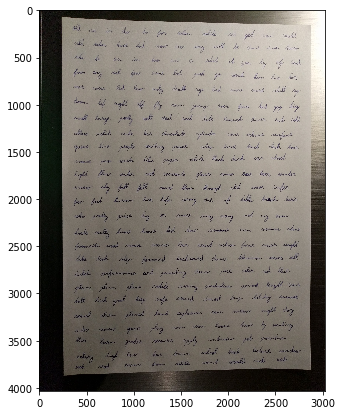

In [5]:
image = cv2.cvtColor(cv2.imread("data/pagedet/%s.jpg" % IMG), cv2.COLOR_BGR2RGB)
implt(image)

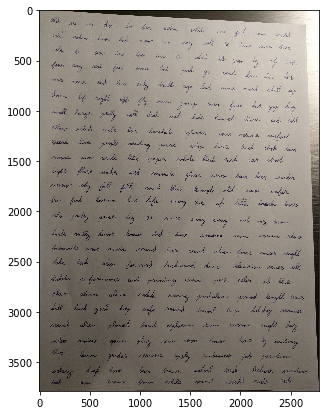

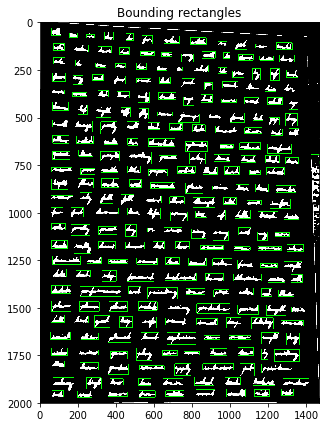

In [6]:
# Crop image and get bounding boxes
crop = page.detection(image)
implt(crop)
bBoxes = words.detection(crop)

# Simple UI using widgets

In [7]:
class Cycler:
    """ Cycle through the words and recognise them """
    height = 60
    
    def __init__(self, image, boxes):
        self.boxes = boxes       # Array of bounding boxes
        self.image = image       # Whole image
        
        
    def recognise(self, img):
        """ Recognising word and printing it """
        # Pre-processing the word
        img = imageNorm(
            img,
            60,
            border=False,
            tilt=True,
            hystNorm=True)
            
        # Separate letters
        img = cv2.copyMakeBorder(
            img,
            0, 0, 30, 30,
            cv2.BORDER_CONSTANT,
            value=[0, 0, 0])
        gaps = characters.segment(img, RNN=True, debug=True)
        
        chars = []
        for i in range(len(gaps)-1):
            char = img[:, gaps[i]:gaps[i+1]]
            # TODO None type error after treshold
            char, dim = letterNorm(char, is_thresh=True, dim=True)
            # TODO Test different values
            if dim[0] > 4 and dim[1] > 4:
                chars.append(char.flatten())
                
        chars = np.array(chars)
        word = ''        
        if len(chars) != 0:
            pred = CHARACTER_MODEL.run(chars)                
            for c in pred:
                word += idx2char(c)
                
        print("Word: " + word)

        
    def idxImage(self, index):
        """ Getting next image from the array """
        if index < len(self.boxes):
            b = self.boxes[index]
            x1, y1, x2, y2 = b
            
            # Cuting out the word image
            img = self.image[y1:y2, x1:x2]            
            implt(img, t='Index: ' + str(index)) 
            
            self.recognise(img)

In [8]:
cycler = Cycler(crop, bBoxes)

# Interactive slider
slider = IntSlider(
    value=0,
    min=0,
    max=len(bBoxes)-1,
    step=1,
    description='Index',
    continuous_update=False)

interact(
    cycler.idxImage,
    index = slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Index', max=258), Output()), _d…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>